In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np


def residual_block(x, filters, kernel_size=3, strides=1, use_projection=False):
    """
    Basic residual block with 2 conv layers
    """
    shortcut = x

    # First conv layer
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Second conv layer
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    # Handle shortcut connection if dimensions change
    if use_projection:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to main path
    y = Add()([y, shortcut])
    y = Activation('relu')(y)

    return y

def build_efficient_resnet(input_shape=(32, 32, 3), classes=10, base_filters=16, n_blocks=4):
    """
    Build a parameter-efficient ResNet for CIFAR-10

    Parameters:
    - input_shape: Input image dimensions
    - classes: Number of output classes
    - base_filters: Number of base filters (multiplied in deeper layers)
    - n_blocks: Number of residual blocks per stage

    Returns:
    - Keras Model
    """
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(base_filters, 3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stage 1 - base_filters (e.g., 16)
    for i in range(n_blocks):
        x = residual_block(x, base_filters)

    # Stage 2 - base_filters*2 (e.g., 32)
    x = residual_block(x, base_filters*2, strides=2, use_projection=True)
    for i in range(n_blocks-1):
        x = residual_block(x, base_filters*2)

    # Stage 3 - base_filters*4 (e.g., 64)
    x = residual_block(x, base_filters*4, strides=2, use_projection=True)
    for i in range(n_blocks-1):
        x = residual_block(x, base_filters*4)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=x)

    return model

def train_cifar10_resnet():
    """
    Set up and train the ResNet model on CIFAR-10
    """
    # Load CIFAR-10 data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Convert labels to categorical
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomContrast(0.1),
    ])

    # Learning rate scheduler
    def lr_schedule(epoch):
        initial_lr = 0.001
        if epoch < 20:
            return initial_lr
        elif epoch < 27:
            return initial_lr * 0.5
        else:
            return initial_lr * 0.01

    # Create model
    # Try different configs to find the best param count
    base_filters = 32
    n_blocks = 4
    model = build_efficient_resnet(
        input_shape=(32, 32, 3),
        classes=10,
        base_filters=base_filters,
        n_blocks=n_blocks
    )

    # Count parameters
    total_params = model.count_params()
    print(f"Total parameters: {total_params:,}")

    # If more than 5M parameters, adjust the architecture
    if total_params > 5_000_000:
        # Find configuration within 5M parameter budget
        # Decrease base filters or blocks
        base_filters = 24  # Try smaller base filter size
        model = build_efficient_resnet(
            input_shape=(32, 32, 3),
            classes=10,
            base_filters=base_filters,
            n_blocks=n_blocks
        )
        print(f"Adjusted model parameters: {model.count_params():,}")

    # Configure optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        clipnorm=1.0  # Add gradient clipping
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up the training data
    train_ds = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(10000)
        .batch(128)
        .map(lambda x, y: (data_augmentation(x, training=True), y))
        .prefetch(tf.data.AUTOTUNE)
    )


    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=(x_test, y_test),
        callbacks=[
            LearningRateScheduler(lr_schedule),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=25,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'resnet_cifar10_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False
            )
        ]
    )

    # Print model summary
    model.summary()

    return model, history

# # Define configurations to test
# configs = [
#     {'base_filters': 16, 'n_blocks': 3},  # Smallest model
#     {'base_filters': 24, 'n_blocks': 3},  # Medium model
#     {'base_filters': 32, 'n_blocks': 3},  # Larger model
#     {'base_filters': 16, 'n_blocks': 5},  # Deeper model
# ]

# # Check parameter counts for each configuration
# for config in configs:
#     model = build_efficient_resnet(
#         base_filters=config['base_filters'],
#         n_blocks=config['n_blocks']
#     )
#     params = model.count_params()
#     print(f"Config: {config}, Parameters: {params:,}")

# You can uncomment and run this to train the model:
# model, history = train_cifar10_resnet()


Total parameters: 1,089,290
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3074 - loss: 1.9598

391/391 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.3075 - loss: 1.9592 - val_accuracy: 0.4016 - val_loss: 1.6435 - learning_rate: 0.0010
Epoch 2/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4674 - loss: 1.4729

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.4675 - loss: 1.4726 - val_accuracy: 0.4338 - val_loss: 1.7929 - learning_rate: 0.0010
Epoch 3/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5451 - loss: 1.2762

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.5452 - loss: 1.2760 - val_accuracy: 0.5614 - val_loss: 1.3099 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.5960 - loss: 1.1465 - val_accuracy: 0.5330 - val_loss: 1.4612 - learning_rate: 0.0010
Epoch 5/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6390 - loss: 1.0327

391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.6390 - loss: 1.0326 - val_accuracy: 0.5656 - val_loss: 1.4681 - learning_rate: 0.0010
Epoch 6/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6687 - loss: 0.9546

391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6687 - loss: 0.9545 - val_accuracy: 0.5917 - val_loss: 1.2876 - learning_rate: 0.0010
Epoch 7/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6948 - loss: 0.8867

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.6949 - loss: 0.8866 - val_accuracy: 0.6226 - val_loss: 1.1873 - learning_rate: 0.0010
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7113 - loss: 0.8396 - val_accuracy: 0.5335 - val_loss: 1.4729 - learning_rate: 0.0010
Epoch 9/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7332 - loss: 0.7885

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7332 - loss: 0.7885 - val_accuracy: 0.6975 - val_loss: 0.9190 - learning_rate: 0.0010
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.7391 - loss: 0.7587 - val_accuracy: 0.6779 - val_loss: 1.0508 - learning_rate: 0.0010
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7540 - loss: 0.7151 - val_accuracy: 0.6943 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 12/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.7590 - loss: 0.6915 - val_accuracy: 0.6418 - val_loss: 1.1708 - learning_rate: 0.0010
Epoch 13/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7723 - loss: 0.6639

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7723 - loss: 0.6638 - val_accuracy: 0.7261 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 14/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7778 - loss: 0.6392 - val_accuracy: 0.7052 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 15/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7811 - loss: 0.6318

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7811 - loss: 0.6317 - val_accuracy: 0.7635 - val_loss: 0.7051 - learning_rate: 0.0010
Epoch 16/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.7931 - loss: 0.6020 - val_accuracy: 0.7069 - val_loss: 0.9120 - learning_rate: 0.0010
Epoch 17/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7978 - loss: 0.5889 - val_accuracy: 0.7554 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 18/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8065 - loss: 0.5654 - val_accuracy: 0.6631 - val_loss: 1.1776 - learning_rate: 0.0010
Epoch 19/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8109 - loss: 0.5525 - val_accuracy: 0.7093 - val_loss: 0.9661 - learning_rate: 0.0010
Epoch 20/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8106 - loss: 0.5552 - val_accuracy: 0.6966 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 21/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8330 - loss: 0

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8331 - loss: 0.4882 - val_accuracy: 0.8074 - val_loss: 0.5679 - learning_rate: 5.0000e-04
Epoch 22/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8422 - loss: 0.4558 - val_accuracy: 0.7809 - val_loss: 0.6850 - learning_rate: 5.0000e-04
Epoch 23/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8479 - loss: 0.4423

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8479 - loss: 0.4423 - val_accuracy: 0.8122 - val_loss: 0.5600 - learning_rate: 5.0000e-04
Epoch 24/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8459 - loss: 0.4418 - val_accuracy: 0.7650 - val_loss: 0.7499 - learning_rate: 5.0000e-04
Epoch 25/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8530 - loss: 0.4309

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8530 - loss: 0.4309 - val_accuracy: 0.8325 - val_loss: 0.5065 - learning_rate: 5.0000e-04
Epoch 26/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8571 - loss: 0.4127 - val_accuracy: 0.8086 - val_loss: 0.5935 - learning_rate: 5.0000e-04
Epoch 27/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8549 - loss: 0.4207 - val_accuracy: 0.8145 - val_loss: 0.5834 - learning_rate: 5.0000e-04
Epoch 28/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8600 - loss: 0.4073

391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8600 - loss: 0.4072 - val_accuracy: 0.8439 - val_loss: 0.4611 - learning_rate: 1.0000e-05
Epoch 29/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8746 - loss: 0.3688

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8746 - loss: 0.3688 - val_accuracy: 0.8473 - val_loss: 0.4550 - learning_rate: 1.0000e-05
Epoch 30/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8701 - loss: 0.3742 - val_accuracy: 0.8472 - val_loss: 0.4515 - learning_rate: 1.0000e-05


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 32)     │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 32)     │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 32)     │            128 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 32, 32, 32)     │              0 │ add_9[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 32, 32, 32)     │            128 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)   

 Total params: 3,261,600 (12.44 MB)

 Trainable params: 1,086,154 (4.14 MB)

 Non-trainable params: 3,136 (12.25 KB)

 Optimizer params: 2,172,310 (8.29 MB)

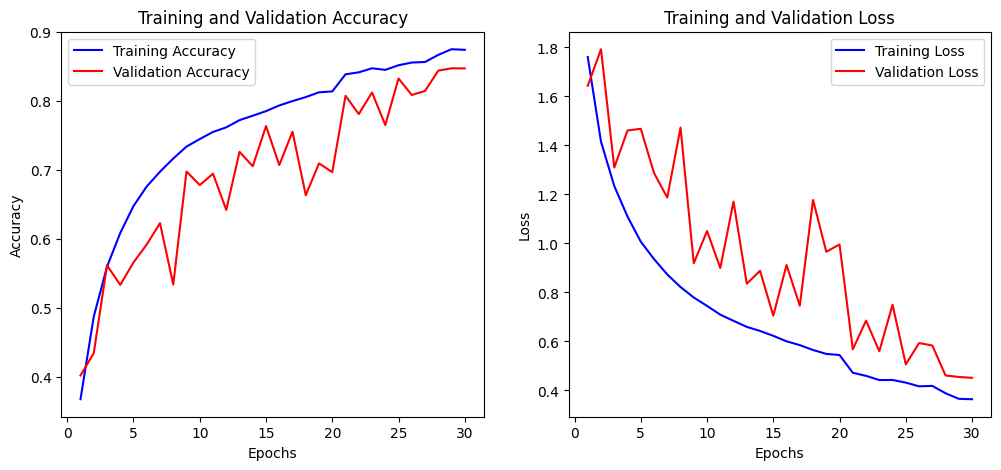

In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_model_history(history)


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[1.6904706e-06 3.0729746e-06 3.1932981e-08 1.4033772e-07 7.0775470e-09
  1.6038484e-08 5.8472740e-08 2.3475186e-08 9.9999225e-01 2.7658182e-06]]
Predicted: ship


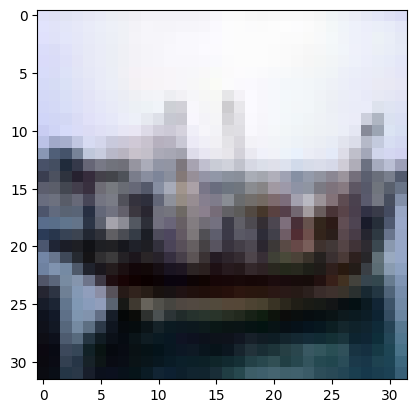

In [ ]:
import random

# Define the label names
label_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Number of random images to select
num_random_images = 5

# Select random indices
# random_indices = random.sample(range(len(x_test)), num_random_images)


plt.imshow(x_test[18])
predictions = model.predict(np.expand_dims(x_test[18], axis=0))
print(predictions)
predicted_label_index = np.argmax(predictions)
predicted_label_name = label_names[predicted_label_index]
print(f"Predicted: {predicted_label_name}")
plt.show()

In [ ]:
x_test = x_test/255.0

In [ ]:
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8442 - loss: 0.4678


[0.45497870445251465, 0.8472999930381775]

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data = unpickle("cifar_test_nolabel.pkl")

In [ ]:
data

{b'data': array([[[[ 19,   1,   1],
          [ 18,   0,   0],
          [ 18,   0,   0],
          ...,
          [123, 115, 113],
          [ 91,  83,  81],
          [107,  99,  97]],
 
         [[ 19,   2,   2],
          [ 18,   0,   0],
          [ 18,   0,   0],
          ...,
          [102,  94,  92],
          [ 66,  58,  56],
          [114, 106, 104]],
 
         [[ 20,   2,   2],
          [ 18,   0,   0],
          [ 18,   0,   0],
          ...,
          [ 60,  52,  51],
          [ 85,  77,  75],
          [126, 118, 116]],
 
         ...,
 
         [[ 44,  38,  25],
          [ 51,  47,  28],
          [ 65,  65,  29],
          ...,
          [ 32,  25,  17],
          [ 57,  52,  32],
          [ 74,  71,  40]],
 
         [[ 68,  66,  30],
          [ 60,  58,  23],
          [ 66,  67,  23],
          ...,
          [ 43,  38,  20],
          [ 48,  43,  24],
          [ 48,  43,  25]],
 
         [[ 93,  92,  46],
          [ 61,  61,  22],
          [ 73,  73, 

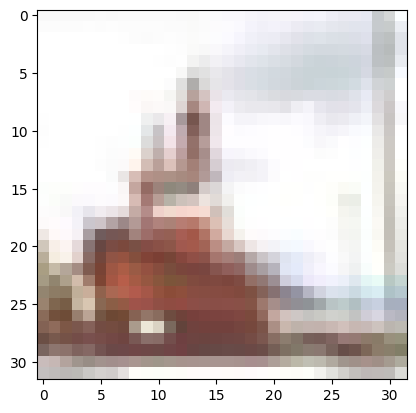

In [ ]:
x_test_nolabel = data.get(b'data', None)
plt.imshow(x_test_nolabel[2])

In [ ]:
x_test_nolabel = x_test_nolabel/255.0
ids = data[b'ids']

results = []

for i, image in enumerate(x_test_nolabel):
    # Expand dims if model expects a batch dimension
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_index = np.argmax(pred)
    pred_label = label_names[pred_index]
    results.append({'id': ids[i], 'predicted_label': pred_label})

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/s

In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df.to_csv('predictions.csv', index=False)

print("CSV file with predictions created successfully.")

CSV file with predictions created successfully.


In [ ]:
df.shape

(10000, 2)

In [ ]:
df.head()

,id,predicted_label
0,0,deer
1,1,deer
2,2,deer
3,3,deer
4,4,deer


In [ ]:
df.tail()

,id,predicted_label
9995,9995,deer
9996,9996,deer
9997,9997,deer
9998,9998,deer
9999,9999,deer


In [ ]:
df.iloc[5513]

,5513
id,5513
predicted_label,deer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


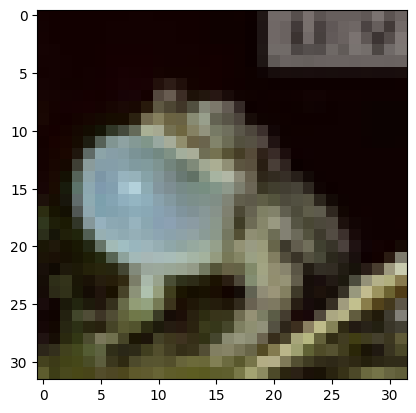

[[0.00073267 0.06140118 0.00156197 0.00340689 0.00467214 0.00136844
  0.39171788 0.0014291  0.00097058 0.53273916]]
truck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


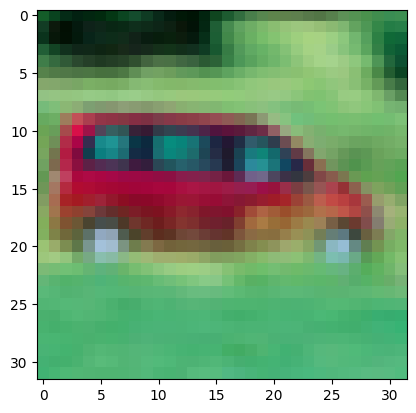

[[7.4174772e-05 9.9979514e-01 2.2378739e-05 6.4903747e-06 2.9054237e-07
  7.9701977e-06 1.1060776e-05 3.7172987e-07 4.0516130e-05 4.1668558e-05]]
automobile
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


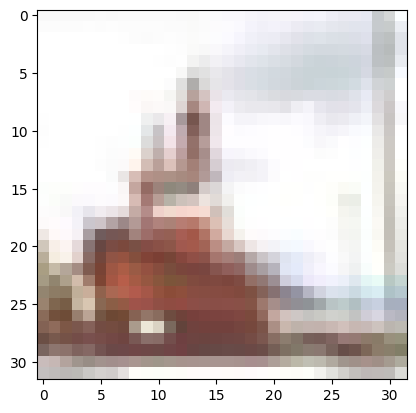

[[6.5102644e-04 2.7015721e-04 1.3340123e-04 5.0172480e-03 2.3683927e-04
  2.3817884e-04 3.8092370e-05 2.8109780e-04 9.9254966e-01 5.8426964e-04]]
ship
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


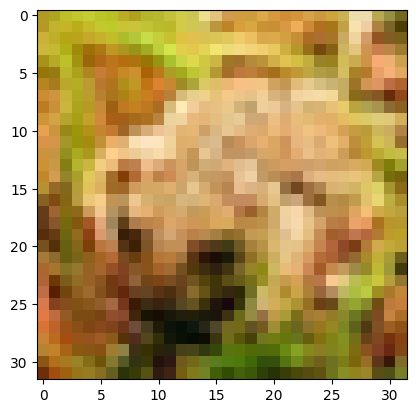

[[8.2570475e-09 4.1461924e-08 1.9107405e-05 4.3585969e-05 4.7870667e-06
  1.8483580e-06 9.9993038e-01 7.9719896e-08 4.9560715e-08 9.4207884e-08]]
frog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


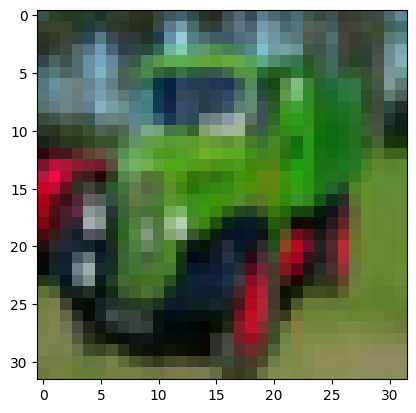

[[2.4590601e-04 5.4427338e-01 1.5056204e-02 1.5166099e-03 6.2854684e-05
  1.4055439e-03 4.0499613e-02 1.4420412e-04 6.2786268e-05 3.9673281e-01]]
automobile
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


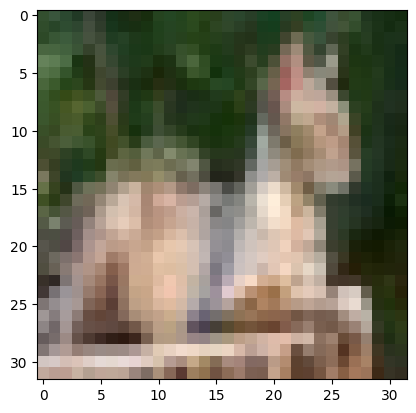

[[1.4959525e-04 2.3221782e-04 5.1105011e-01 2.4279250e-01 1.5052589e-02
  5.1273718e-03 1.4036934e-01 7.7764720e-02 7.1460186e-03 3.1563753e-04]]
bird
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


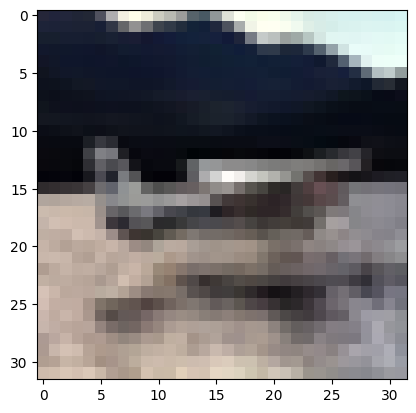

[[0.6910079  0.0011949  0.14572886 0.0235578  0.01984876 0.00616396
  0.00883541 0.02639217 0.07604937 0.00122092]]
airplane
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


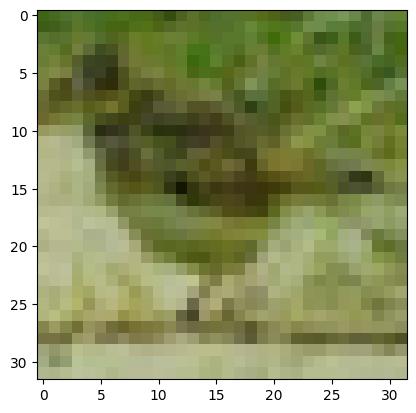

[[8.0946738e-05 6.8496156e-06 8.0497020e-01 2.3845485e-03 2.4735131e-03
  1.5335085e-04 1.8972544e-01 3.5118414e-05 1.5538032e-04 1.4661621e-05]]
bird
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


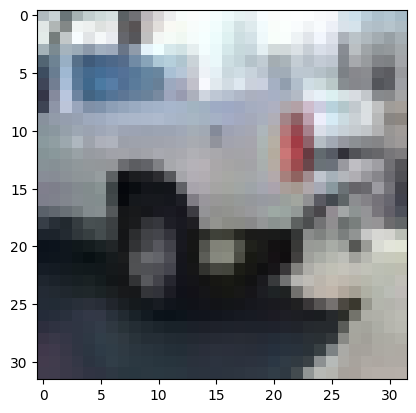

[[1.1334335e-05 1.8296843e-02 1.2927186e-06 4.8523275e-06 5.8542935e-07
  2.5954139e-06 2.7405571e-07 3.8268084e-07 2.3787279e-06 9.8167944e-01]]
truck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


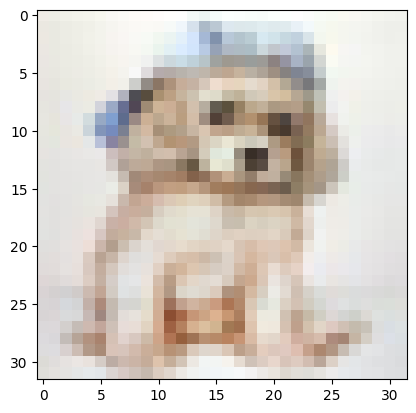

[[2.4531626e-05 3.7547652e-05 5.8315308e-03 2.4387727e-03 4.2636915e-05
  9.8658270e-01 3.9234529e-03 5.1416107e-05 1.0201168e-03 4.7241050e-05]]
dog


In [ ]:
ids = data[b'ids']

results = []

for i in range(10):
    # Expand dims if model expects a batch dimension
    image = x_test_nolabel[i].astype(np.float64) / 255.0
    # Expand dims if model expects a batch dimension
    pred = model.predict(np.expand_dims(image, axis=0))
    plt.imshow(image)
    plt.show()
    print(pred)
    pred_index = np.argmax(pred)
    pred_label = label_names[pred_index]
    print(pred_label)
    results.append({'id': ids[i], 'predicted_label': pred_label})

Shape: (32, 32, 3)
Data type: float64
Min value: 0.0 Max value: 0.8588235294117647


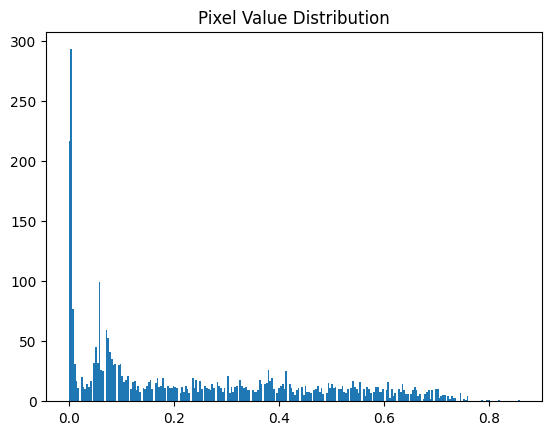

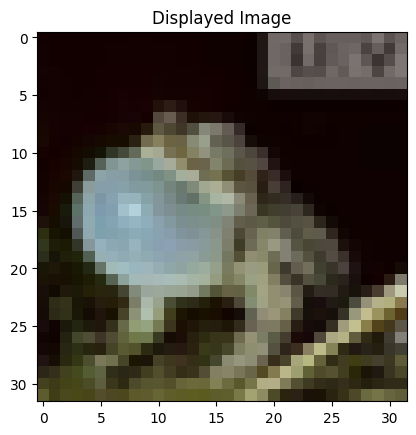

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image' is your image array (for example, x_test[0])
image = x_test_nolabel[0]
image = image.astype(np.float64) / 255.0

# Check the shape (e.g., (height, width, channels))
print("Shape:", image.shape)

# Check the data type (e.g., uint8, float32)
print("Data type:", image.dtype)

# Check the minimum and maximum values in the image
print("Min value:", np.min(image), "Max value:", np.max(image))

# Optionally, show a histogram of pixel values to see the distribution
plt.hist(image.ravel(), bins=256, fc='k', ec='k')
plt.title("Pixel Value Distribution")
plt.show()

# Display the image using plt.imshow (adjust colormap if necessary)
plt.imshow(image)
plt.title("Displayed Image")
plt.show()


Shape: (32, 32, 3)
Data type: float64
Min value: 0.0 Max value: 1.0


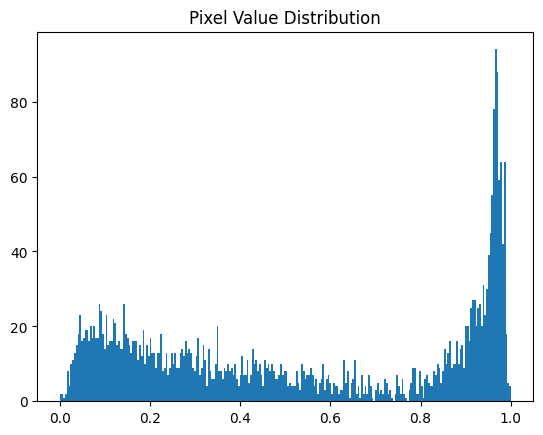

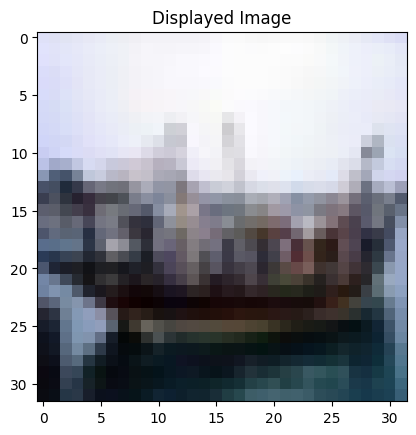

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image' is your image array (for example, x_test[0])
image = x_test[18]

# Check the shape (e.g., (height, width, channels))
print("Shape:", image.shape)

# Check the data type (e.g., uint8, float32)
print("Data type:", image.dtype)

# Check the minimum and maximum values in the image
print("Min value:", np.min(image), "Max value:", np.max(image))

# Optionally, show a histogram of pixel values to see the distribution
plt.hist(image.ravel(), bins=256, fc='k', ec='k')
plt.title("Pixel Value Distribution")
plt.show()

# Display the image using plt.imshow (adjust colormap if necessary)
plt.imshow(image)
plt.title("Displayed Image")
plt.show()


In [ ]:
ids = data[b'ids']

results = []

for i, image in enumerate(x_test_nolabel):
    # Expand dims if model expects a batch dimension
    image = image.astype(np.float64) / 255.0
    # Expand dims if model expects a batch dimension
    pred = model.predict(np.expand_dims(image, axis=0))
    # plt.imshow(image)
    # plt.show()
    # print(pred)
    pred_index = np.argmax(pred)
    pred_label = label_names[pred_index]
    # print(pred_label)
    results.append({'id': ids[i], 'predicted_label': pred_label})
    print(i)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7502
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
7519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
7520
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7521
1/1

In [ ]:
import pandas

df = pandas.read_csv('predictions.csv')

df.tail()

,id,predicted_label
9995,9995,deer
9996,9996,deer
9997,9997,deer
9998,9998,deer
9999,9999,deer


In [ ]:
results[0]

{'id': 0, 'predicted_label': 'truck'}

In [ ]:
import pandas as pd

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file (without the index)
df.to_csv('predictions.csv', index=False)

print("CSV file created successfully!")

CSV file created successfully!


In [ ]:
import pandas

df = pandas.read_csv('predictions.csv')

df.tail()

,id,predicted_label
9995,9995,ship
9996,9996,airplane
9997,9997,bird
9998,9998,cat
9999,9999,automobile


In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(label_names)}


In [ ]:
print(label_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [ ]:
for item in results:
    # Convert the string label to its numeric index
    item['predicted_label'] = label_to_idx[item['predicted_label']]


In [ ]:
results[0]

{'id': 0, 'predicted_label': 9}

In [ ]:
import pandas as pd

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file (without the index)
df.to_csv('predictions2.csv', index=False)

print("CSV file created successfully!")

CSV file created successfully!


In [ ]:
df

In [ ]:
df.rename(columns={'id': 'ID', 'predicted_label': 'Label'}, inplace=True)

AttributeError: 'NoneType' object has no attribute 'rename'

In [ ]:
df.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
df.to_csv('predictions2.csv', index=False)

print("CSV file created successfully!")


CSV file created successfully!
